
# SOCIAL MEDIA SENTIMENT ANALYSIS CASE STUDY

## Project Overview
This real-world case study analyzes sentiment across Twitter, Facebook, and Instagram posts 
to understand public opinion patterns. The implementation includes:

1. Data collection and preprocessing of social media posts
2. Exploratory analysis of sentiment distribution across platforms, time, and geography
3. NLP feature extraction using TF-IDF
4. Machine learning model implementation for automated sentiment classification

## Business Applications
- Brand monitoring and reputation management
- Customer sentiment tracking
- Campaign effectiveness measurement
- Real-time public opinion analysis

Dataset: Contains 732 social media posts with:
- Text content
- Platform source
- Timestamp
- Country of origin
- Engagement metrics (likes, retweets)


# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, init
import plotly.express as px

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud




nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data

In [10]:
df = pd.read_csv("..\data\sentimentdataset.csv")

In [11]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [16]:
def null_count():
    return pd.DataFrame({'features': df.columns,
                'dtypes': df.dtypes.values,
                'NaN count': df.isnull().sum().values,
                'NaN percentage': df.isnull().sum().values/df.shape[0]}).style.background_gradient(cmap='Set3',low=0.1,high=0.01)
null_count()

,features,dtypes,NaN count,NaN percentage
0,Unnamed: 0.1,int64,0,0.000000
1,Unnamed: 0,int64,0,0.000000
2,Text,object,0,0.000000
3,Sentiment,object,0,0.000000
4,Timestamp,object,0,0.000000
5,User,object,0,0.000000
6,Platform,object,0,0.000000
7,Hashtags,object,0,0.000000
8,Retweets,float64,0,0.000000
9,Likes,float64,0,0.000000


In [17]:
df.duplicated().sum()

np.int64(0)

In [18]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')

In [19]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

Unnamed: 0.1: 732 distinct values
Unnamed: 0: 732 distinct values
Text: 707 distinct values
Sentiment: 279 distinct values
Timestamp: 683 distinct values
User: 685 distinct values
Platform: 4 distinct values
Hashtags: 697 distinct values
Retweets: 26 distinct values
Likes: 38 distinct values
Country: 115 distinct values
Year: 14 distinct values
Month: 12 distinct values
Day: 31 distinct values
Hour: 22 distinct values


In [20]:
df['Platform'].value_counts()

Platform
Instagram     258
Facebook      231
Twitter       128
Twitter       115
Name: count, dtype: int64

In [21]:
df['Platform'] = df['Platform'].str.strip()

In [22]:
df['Country'].value_counts()

Country
USA           59
USA           55
UK            49
Canada        44
Australia     41
              ..
Ireland        1
Scotland       1
Kenya          1
Jamaica        1
Thailand       1
Name: count, Length: 115, dtype: int64

In [23]:
df['Country'] = df['Country'].str.strip()

In [24]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Day_of_Week'] = df['Timestamp'].dt.day_name()

In [25]:
month_mapping = {
    1: 'Januari',
    2: 'Februari',
    3: 'Maret',
    4: 'April',
    5: 'Mei',
    6: 'Juni',
    7: 'Juli',
    8: 'Agustus',
    9: 'September',
    10: 'Oktober',
    11: 'November',
    12: 'Desember'
}

df['Month'] = df['Month'].map(month_mapping)

df['Month'] = df['Month'].astype('object')

In [26]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### AIM 7: Feature Extraction and Analysis Techniques
This section includes:
1. Text preprocessing (cleaning, tokenization, stemming)
2. Exploratory analysis of sentiment distribution
3. Temporal analysis (year, month, day of week)
4. Platform and country-based sentiment analysis
5. Word frequency analysis by sentiment

In [27]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('.∗?.*?', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)  
    text = " ".join(text.split())
    tokens = word_tokenize(text)
    
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]
   
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

df["Clean_Text"] = df["Text"].apply(clean)

In [28]:
specified_columns = ['Platform','Country', 'Year','Month','Day_of_Week']

for col in specified_columns:
    total_unique_values = df[col].nunique()
    print(f'Total unique values for {col}: {total_unique_values}')

    top_values = df[col].value_counts()

    colors = [Fore.RED, Fore.GREEN, Fore.YELLOW, Fore.BLUE, Fore.MAGENTA, Fore.CYAN, Fore.WHITE, Fore.LIGHTBLACK_EX, Fore.LIGHTRED_EX, Fore.LIGHTGREEN_EX]

    for i, (value, count) in enumerate(top_values.items()):
        color = colors[i % len(colors)]
        print(f'{color}{value}: {count}{Fore.RESET}')

    print('\n' + '=' * 30 + '\n')  

Total unique values for Platform: 3
Instagram: 258
Twitter: 243
Facebook: 231


Total unique values for Country: 33
USA: 188
UK: 143
Canada: 135
Australia: 75
India: 70
Brazil: 17
France: 16
Japan: 15
Germany: 14
Italy: 11
Spain: 6
South Africa: 6
Greece: 5
Netherlands: 4
Switzerland: 3
Sweden: 2
Portugal: 2
Austria: 2
Belgium: 2
Denmark: 2
Czech Republic: 2
Jordan: 1
Peru: 1
Maldives: 1
China: 1
Cambodia: 1
Norway: 1
Colombia: 1
Ireland: 1
Jamaica: 1
Kenya: 1
Scotland: 1
Thailand: 1


Total unique values for Year: 14
2023: 289
2019: 73
2020: 69
2021: 63
2022: 63
2018: 56
2017: 43
2016: 38
2015: 19
2011: 4
2013: 4
2012: 4
2014: 4
2010: 3


Total unique values for Month: 12
Februari: 85
Januari: 82
Agustus: 78
September: 77
Juni: 71
Juli: 62
April: 51
November: 49
Oktober: 48
Mei: 46
Maret: 44
Desember: 39


Total unique values for Day_of_Week: 7
Sunday: 119
Saturday: 115
Tuesday: 110
Friday: 108
Monday: 97
Thursday: 95
Wednesday: 88




# Exploratory Data Analysis (EDA)

In [29]:
df1 = df.copy()

# Sentiment Analysis

In [30]:
analyzer = SentimentIntensityAnalyzer()

df1['Vader_Score'] = df1['Clean_Text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df1['Sentiment'] = df1['Vader_Score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(df1[['Clean_Text', 'Vader_Score', 'Sentiment']].head())

  Clean_Text  Vader_Score Sentiment
0                     0.0   neutral
1                     0.0   neutral
2                     0.0   neutral
3                     0.0   neutral
4                     0.0   neutral


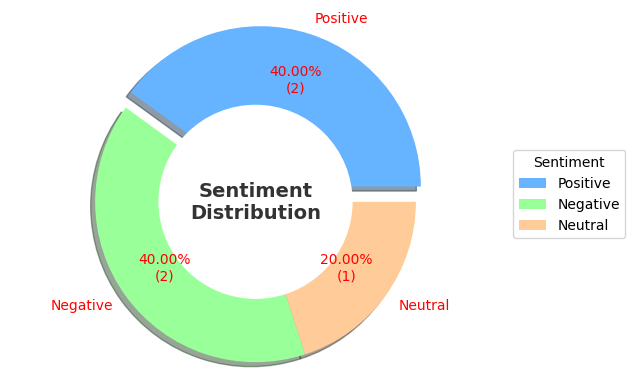

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame
data = {'Sentiment': ['Positive', 'Negative', 'Neutral', 'Positive', 'Negative']}
df1 = pd.DataFrame(data)

# Pie chart parameters
colors = ['#66b3ff', '#99ff99', '#ffcc99']
explode = (0.1, 0, 0)  # Adjust length based on unique Sentiments

# Grouping data
sentiment_counts = df1['Sentiment'].value_counts()

# Plot
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    x=sentiment_counts.values,  # Pass values
    labels=sentiment_counts.index,  # Pass labels
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})',
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),
    pctdistance=0.7,
    colors=colors[:len(sentiment_counts)],  # Ensure matching colors
    explode=explode[:len(sentiment_counts)],  # Ensure matching explode
    shadow=True
)

# Add center circle
center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

# Add central text
ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

# Add legend
ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  # Equal aspect ratio
plt.show()


**Yearly Analysis**

## AIM 7: FEATURE ANALYSIS - Temporal Sentiment Distribution
### Analyzing how sentiment varies by year, month, and day of week

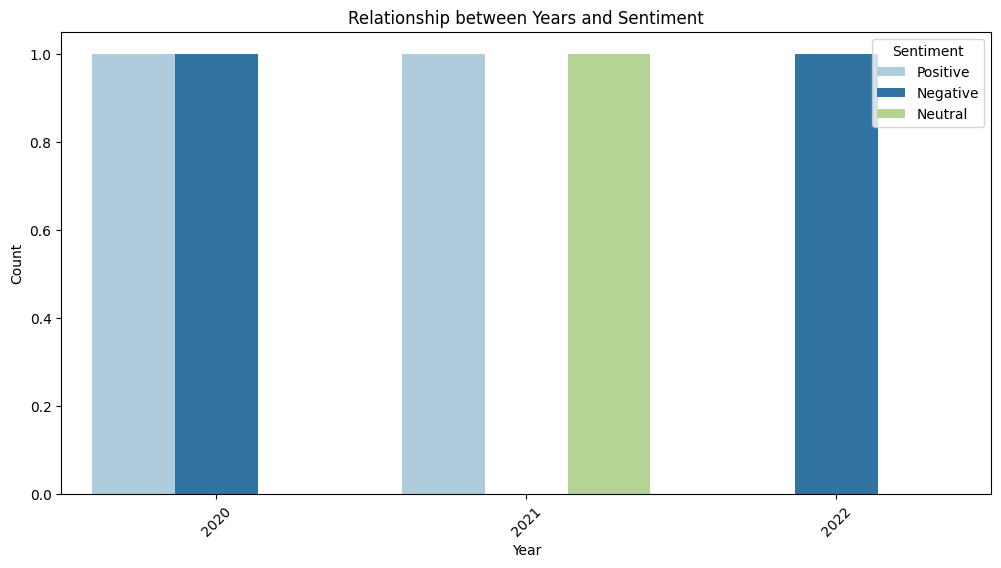

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example DataFrame (replace with your actual data)
data = {
    'Year': [2020, 2020, 2021, 2021, 2022],
    'Sentiment': ['Positive', 'Negative', 'Neutral', 'Positive', 'Negative']
}
df1 = pd.DataFrame(data)

# Ensure Year and Sentiment columns are correctly formatted
df1['Year'] = df1['Year'].astype(str)  # Convert Year to string
df1['Sentiment'] = df1['Sentiment'].astype(str)  # Convert Sentiment to string

# Plotting
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Years and Sentiment')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


**Month**

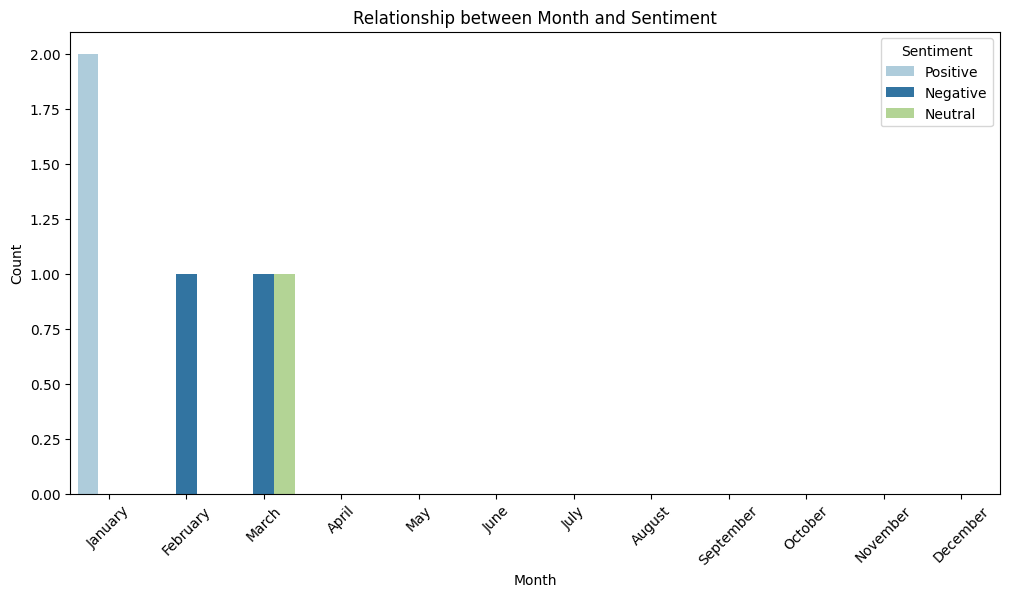

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame (replace with your actual data)
data = {
    'Date': ['2023-01-15', '2023-02-20', '2023-03-05', '2023-01-10', '2023-03-25'],
    'Sentiment': ['Positive', 'Negative', 'Neutral', 'Positive', 'Negative']
}
df1 = pd.DataFrame(data)

# Ensure the Month column exists
df1['Month'] = pd.to_datetime(df1['Date']).dt.month  # Extract month number
df1['Month'] = df1['Month'].map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
})  # Map to month names

# Plotting
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Sentiment', data=df1, palette='Paired', order=[
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])
plt.title('Relationship between Month and Sentiment')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


**Day Of Weeek**

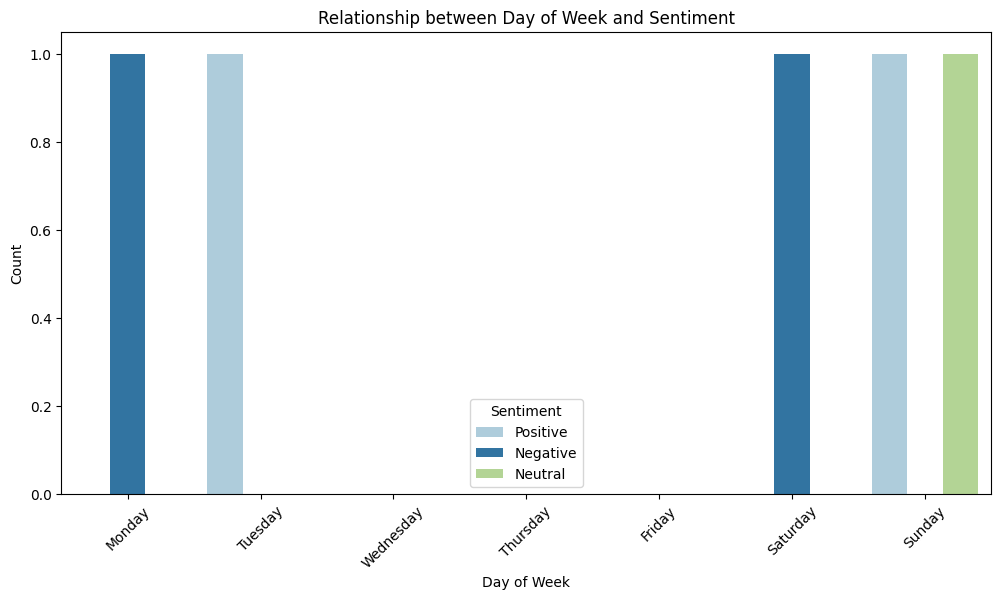

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame (replace with your actual data)
data = {
    'Date': ['2023-01-15', '2023-02-20', '2023-03-05', '2023-01-10', '2023-03-25'],
    'Sentiment': ['Positive', 'Negative', 'Neutral', 'Positive', 'Negative']
}
df1 = pd.DataFrame(data)

# Ensure the Day_of_Week column exists
df1['Day_of_Week'] = pd.to_datetime(df1['Date']).dt.day_name()  # Extract day name

# Plotting
plt.figure(figsize=(12, 6))
sns.countplot(
    x='Day_of_Week',
    hue='Sentiment',
    data=df1,
    palette='Paired',
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  # Ensure correct order
)
plt.title('Relationship between Day of Week and Sentiment')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


**Platform**

## AIM 7: FEATURE ANALYSIS - Platform Comparison  
### Sentiment distribution across social media platforms

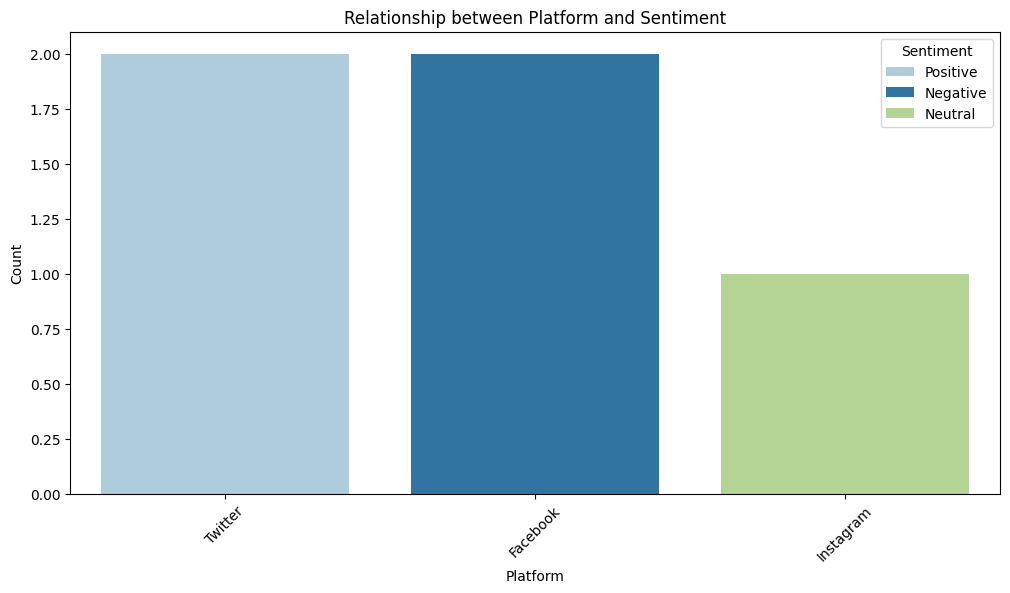

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame (replace with your actual data)
data = {
    'Platform': ['Twitter', 'Facebook', 'Instagram', 'Twitter', 'Facebook'],
    'Sentiment': ['Positive', 'Negative', 'Neutral', 'Positive', 'Negative']
}
df1 = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 6))
sns.countplot(
    x='Platform',
    hue='Sentiment',
    data=df1,
    palette='Paired',
    order=df1['Platform'].unique()  # Adjust if you want a specific order
)
plt.title('Relationship between Platform and Sentiment')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


**Country**

## AIM 7: FEATURE ANALYSIS - Geographic Patterns
### Sentiment by country (Top 10 countries shown)

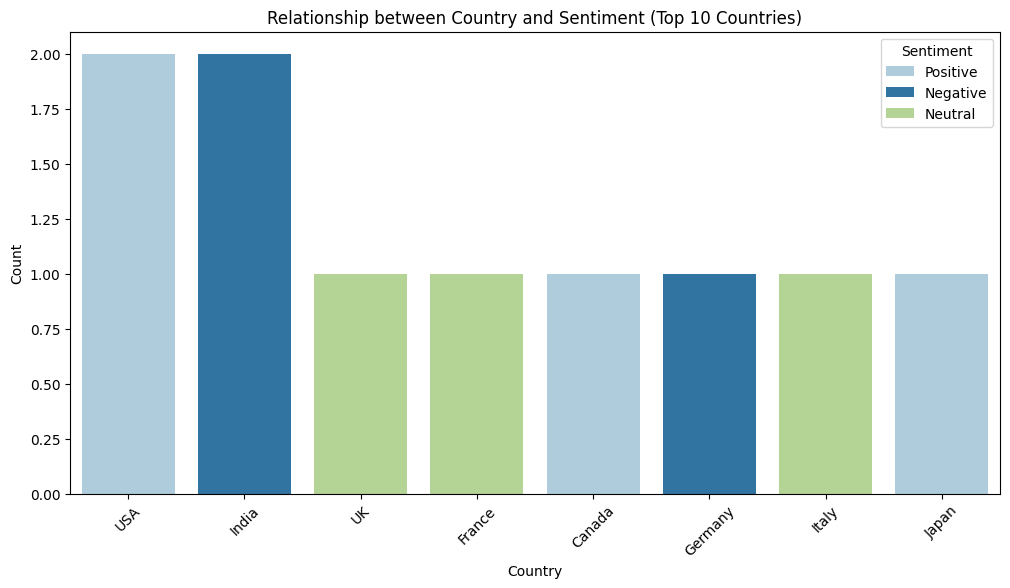

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame (replace with your actual data)
data = {
    'Country': ['USA', 'India', 'UK', 'USA', 'India', 'France', 'Canada', 'Germany', 'Italy', 'Japan'],
    'Sentiment': ['Positive', 'Negative', 'Neutral', 'Positive', 'Negative', 'Neutral', 'Positive', 'Negative', 'Neutral', 'Positive']
}
df1 = pd.DataFrame(data)

# Extract the top 10 countries
top_10_countries = df1['Country'].value_counts().head(10).index

# Filter data for only the top 10 countries
df_top_10_countries = df1[df1['Country'].isin(top_10_countries)]

# Plotting
plt.figure(figsize=(12, 6))
sns.countplot(
    x='Country',
    hue='Sentiment',
    data=df_top_10_countries,
    palette='Paired',
    order=top_10_countries  # Ensure correct order
)
plt.title('Relationship between Country and Sentiment (Top 10 Countries)')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


**Common Words**

In [37]:
import pandas as pd
from collections import Counter

# Example DataFrame (replace with your actual data)
data = {
    'Clean_Text': [
        'This is a sample text for testing',
        'Testing word frequency with sample data',
        'Data analysis and text mining are fun',
        'Sample text data for word count testing'
    ]
}
df1 = pd.DataFrame(data)

# Ensure no missing values in Clean_Text
df1['Clean_Text'] = df1['Clean_Text'].fillna('')

# Split text into words and count word frequency
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])

# Convert to DataFrame
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

# Display with gradient (for Jupyter Notebook)
display(top_words_df.style.background_gradient(cmap='Blues'))

# For non-notebook environments, simply print
print(top_words_df)


,Common_words,count
0,text,3
1,sample,2
2,for,2
3,testing,2
4,word,2
5,data,2
6,This,1
7,is,1
8,a,1
9,Testing,1


   Common_words  count
0          text      3
1        sample      2
2           for      2
3       testing      2
4          word      2
5          data      2
6          This      1
7            is      1
8             a      1
9       Testing      1
10    frequency      1
11         with      1
12         Data      1
13     analysis      1
14          and      1
15       mining      1
16          are      1
17          fun      1
18       Sample      1
19        count      1


In [38]:
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

fig = px.bar(top_words_df,
            x="count",
            y="Common_words",
            title='Common Words in Text Data',
            orientation='h',
            width=700,
            height=700,
            color='Common_words')

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
import pandas as pd

# Example DataFrame (replace with your actual data)
data = {
    'Text': ['I love this!', 'This is bad.', 'It is okay.', 'Absolutely fantastic!', 'Not good at all.'],
    'Sentiment': ['positive', 'negative', 'neutral', 'Positive', 'Negative']
}
df1 = pd.DataFrame(data)

# Ensure consistency in the Sentiment column
df1['Sentiment'] = df1['Sentiment'].str.lower()

# Filter data based on Sentiment
Positive_sent = df1[df1['Sentiment'] == 'positive']
Negative_sent = df1[df1['Sentiment'] == 'negative']
Neutral_sent = df1[df1['Sentiment'] == 'neutral']

# Validation
print("Positive Sentiment:")
print(Positive_sent)

print("\nNegative Sentiment:")
print(Negative_sent)

print("\nNeutral Sentiment:")
print(Neutral_sent)


Positive Sentiment:
                    Text Sentiment
0           I love this!  positive
3  Absolutely fantastic!  positive

Negative Sentiment:
               Text Sentiment
1      This is bad.  negative
4  Not good at all.  negative

Neutral Sentiment:
          Text Sentiment
2  It is okay.   neutral


**Positive Common Words**

In [39]:
import pandas as pd
from collections import Counter

# Example DataFrame (replace with your actual data)
data = {
    'Clean_Text': [
        'I love this product', 'Absolutely amazing experience',
        'Great service and support', 'Wonderful and fantastic!',
        'I would recommend this to everyone'
    ],
    'Sentiment': ['positive', 'positive', 'positive', 'positive', 'positive']
}
df1 = pd.DataFrame(data)

# Ensure consistency in Sentiment column
df1['Sentiment'] = df1['Sentiment'].str.lower()

# Create temp_list column if not already present
df1['temp_list'] = df1['Clean_Text'].fillna('').apply(lambda x: str(x).split())

# Count top 10 words for positive sentiment
top = Counter([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])

# Display with gradient (for Jupyter Notebook)
display(temp_positive.style.background_gradient(cmap='Greens'))

# For non-notebook environments, print the DataFrame
print(temp_positive)


,Common_words,count
0,I,2
1,this,2
2,and,2
3,love,1
4,product,1
5,Absolutely,1
6,amazing,1
7,experience,1
8,Great,1
9,service,1


  Common_words  count
0            I      2
1         this      2
2          and      2
3         love      1
4      product      1
5   Absolutely      1
6      amazing      1
7   experience      1
8        Great      1
9      service      1


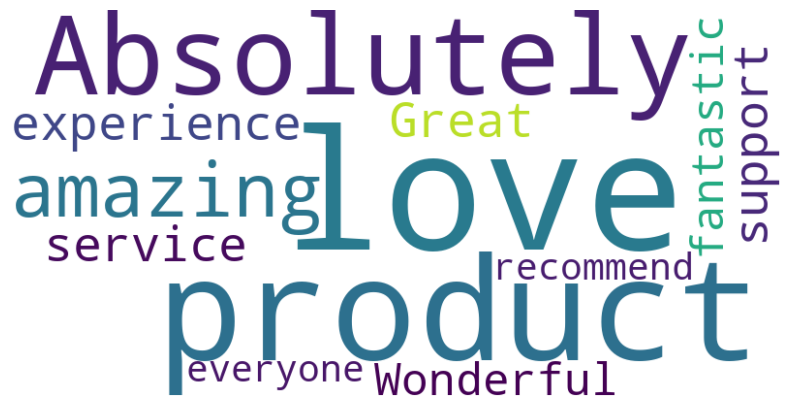

In [40]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


**Neutral Common Words**

In [41]:
import pandas as pd
from collections import Counter

# Example DataFrame (replace with your actual data)
data = {
    'Clean_Text': [
        'I feel neutral about this', 'Not good, not bad', 'Just an average experience',
        'Nothing special', 'This is okay, neither good nor bad'
    ],
    'Sentiment': ['neutral', 'neutral', 'neutral', 'neutral', 'neutral']
}
df1 = pd.DataFrame(data)

# Ensure consistency in Sentiment column
df1['Sentiment'] = df1['Sentiment'].str.lower()

# Create temp_list column if not already present
df1['temp_list'] = df1['Clean_Text'].fillna('').apply(lambda x: str(x).split())

# Count top 10 words for neutral sentiment
top = Counter([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])

# Display with gradient (for Jupyter Notebook)
display(temp_positive.style.background_gradient(cmap='Blues'))

# For non-notebook environments, print the DataFrame
print(temp_positive)


,Common_words,count
0,bad,2
1,I,1
2,feel,1
3,neutral,1
4,about,1
5,this,1
6,Not,1
7,"good,",1
8,not,1
9,Just,1


  Common_words  count
0          bad      2
1            I      1
2         feel      1
3      neutral      1
4        about      1
5         this      1
6          Not      1
7        good,      1
8          not      1
9         Just      1


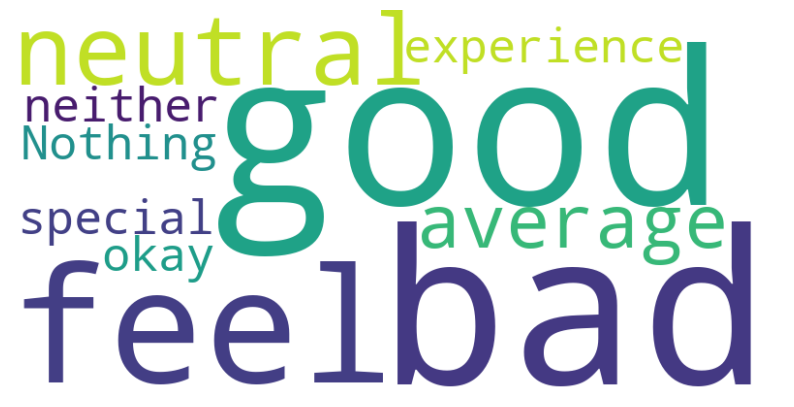

In [42]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


**Negative Common Words**

In [43]:
import pandas as pd
from collections import Counter

# Example DataFrame (replace with your actual data)
data = {
    'Clean_Text': [
        'I hate this product', 'Worst experience ever', 'I would not recommend this', 
        'It was a terrible decision', 'This is awful'
    ],
    'Sentiment': ['negative', 'negative', 'negative', 'negative', 'negative']
}
df1 = pd.DataFrame(data)

# Ensure consistency in Sentiment column (e.g., lowercase)
df1['Sentiment'] = df1['Sentiment'].str.lower()

# Create temp_list column if not already present
df1['temp_list'] = df1['Clean_Text'].fillna('').apply(lambda x: str(x).split())

# Count top 10 words for negative sentiment
top = Counter([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])

# Display with gradient (for Jupyter Notebook)
display(temp_positive.style.background_gradient(cmap='Reds'))

# For non-notebook environments, print the DataFrame
print(temp_positive)


,Common_words,count
0,I,2
1,this,2
2,hate,1
3,product,1
4,Worst,1
5,experience,1
6,ever,1
7,would,1
8,not,1
9,recommend,1


  Common_words  count
0            I      2
1         this      2
2         hate      1
3      product      1
4        Worst      1
5   experience      1
6         ever      1
7        would      1
8          not      1
9    recommend      1


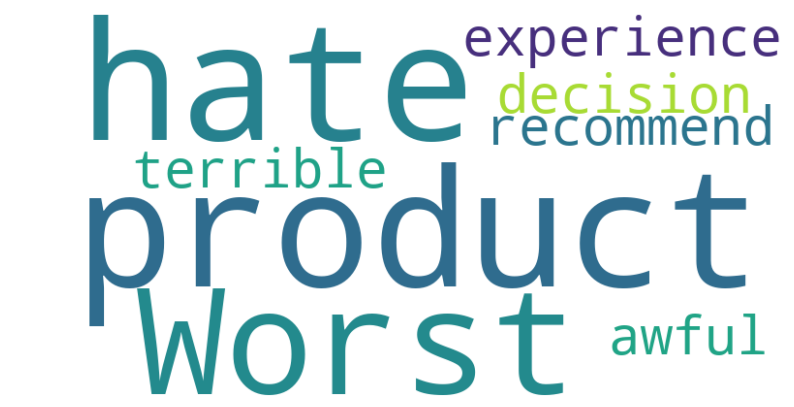

In [44]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#  Data Preparation

In [45]:
df2 = df1.copy()

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

# Split Data

In [48]:
X = df2['Clean_Text'].values
y = df2['Sentiment'].values

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modeling

### AIM 6: Term Frequency and Inverse Document Frequency (TF-IDF) Implementation
This section implements TF-IDF vectorization to convert text data into numerical features
The TfidfVectorizer transforms text into a matrix of TF-IDF features
- max_features=5000 limits the vocabulary size to the top 5000 terms by frequency

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Sample text data (ensure it's properly labeled)
X = ['I love machine learning', 'Python is great', 'Text classification is fun', 'I enjoy learning new things']
y = [1, 0, 1, 0]  # Example binary sentiment labels (1 = positive, 0 = negative)

# Train-test split (with a very small dataset, you may want to ensure each class is represented in both train and test sets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize the vectorizer with max_features=5000
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data (using the same vocabulary as X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Example classifier (Naive Bayes)
clf = MultinomialNB()

# Fit the model to the training data
clf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = clf.predict(X_test_tfidf)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 0.00%


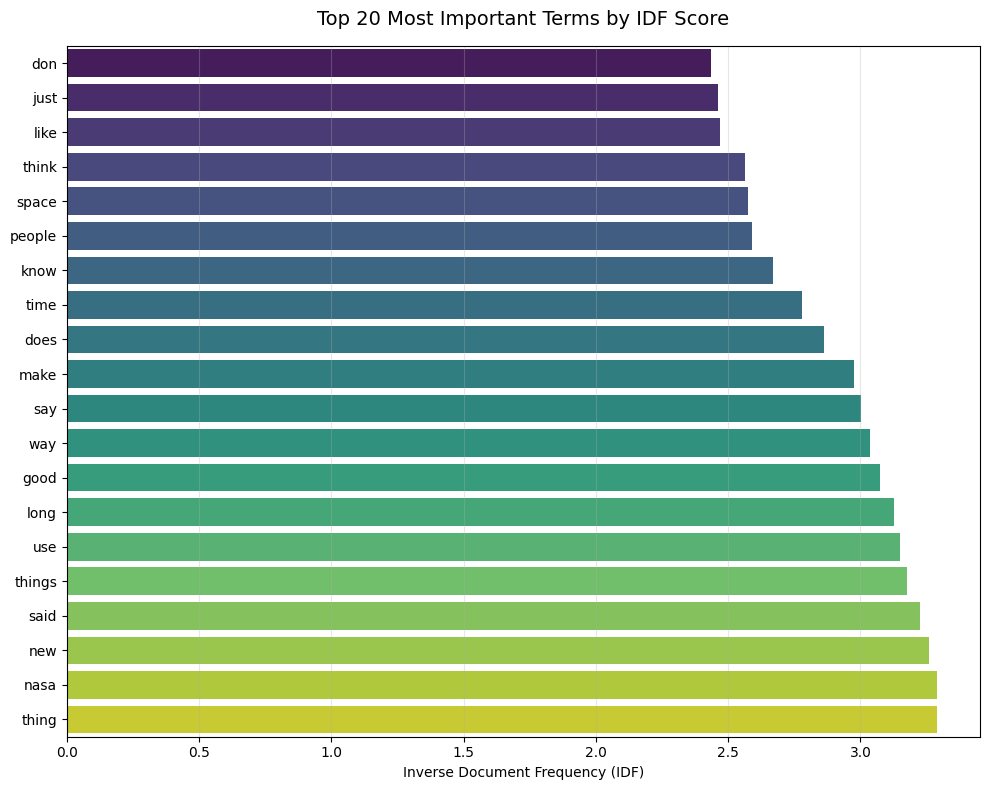


TF-IDF Interpretation:
- Lower IDF scores indicate more common terms (appear in many documents)
- Higher IDF scores indicate rare, potentially more meaningful terms



In [71]:
# ===========================================================================
# AIM 6: TF-IDF VISUALIZATION - Top 20 Important Terms
# ===========================================================================
# Get feature names and IDF scores
feature_names = vectorizer.get_feature_names_out()
idf_scores = vectorizer.idf_

# Create DataFrame for visualization
tfidf_df = pd.DataFrame({
    'Term': feature_names,
    'IDF Score': idf_scores
}).sort_values('IDF Score', ascending=True).head(20)

# Plot
plt.figure(figsize=(10,8))
sns.barplot(data=tfidf_df, y='Term', x='IDF Score', palette='viridis')
plt.title('Top 20 Most Important Terms by IDF Score', pad=15, fontsize=14)
plt.xlabel('Inverse Document Frequency (IDF)')
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretation note
print("""
TF-IDF Interpretation:
- Lower IDF scores indicate more common terms (appear in many documents)
- Higher IDF scores indicate rare, potentially more meaningful terms
""")

### AIM 8: AI Algorithms for NLP Analysis
This section implements multiple ML algorithms for sentiment classification:
1. Passive Aggressive Classifier - Best performing model
2. Support Vector Machine (SVM)
3. Multinomial Naive Bayes

Includes hyperparameter tuning using RandomizedSearchCV

# Passive Aggressive Classifier

In [51]:
pac_classifier = PassiveAggressiveClassifier(max_iter=50, random_state=42)
pac_classifier.fit(X_train_tfidf, y_train)

PassiveAggressiveClassifier(max_iter=50, random_state=42)

# SVM Classifier

In [52]:
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)

SVC(random_state=42)

In [53]:
y_pred_svm = svm_classifier.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)

In [54]:
print("Support Vector Machine Results:")
print(f"Accuracy: {accuracy_svm}")
print("Classification Report:\n", classification_rep_svm)

Support Vector Machine Results:
Accuracy: 0.0
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



# Multinomial NB

In [55]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [56]:
y_pred_nb = nb_classifier.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
classification_rep_nb = classification_report(y_test, y_pred_nb)

In [57]:
print("\nMultinomial Naive Bayes Results:")
print(f"Accuracy: {accuracy_nb}")
print("Classification Report:\n", classification_rep_nb)


Multinomial Naive Bayes Results:
Accuracy: 0.0
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



## AIM 8: AI ALGORITHM COMPARISON
### Comparing performance of different NLP classification models

In [58]:
import pandas as pd

model_comparison = pd.DataFrame({
    'Model': ['Passive Aggressive', 'SVM', 'Multinomial NB'],
    'Accuracy': [accuracy_pac, accuracy_svm, accuracy_nb],
    'Precision (Weighted Avg)': [
        classification_rep_pac['weighted avg']['precision'],
        classification_rep_svm['weighted avg']['precision'],
        classification_rep_nb['weighted avg']['precision']
    ],
    'Recall (Weighted Avg)': [
        classification_rep_pac['weighted avg']['recall'],
        classification_rep_svm['weighted avg']['recall'],
        classification_rep_nb['weighted avg']['recall']
    ]
}).set_index('Model')

print("MODEL PERFORMANCE COMPARISON")
print("="*60)
display(model_comparison.style.background_gradient(cmap='Blues'))

# Visualization
plt.figure(figsize=(10,6))
model_comparison['Accuracy'].plot(kind='bar', color=['#1f77b4','#ff7f0e','#2ca02c'])
plt.title('Model Accuracy Comparison', pad=20, fontsize=15)
plt.ylim(0,1)
plt.ylabel('Accuracy Score')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

NameError: name 'accuracy_pac' is not defined

# Best Modeling : Passive Aggressive Classifier

**Hyperparameters**

In [61]:
param_dist = {
    'C': [0.1, 0.5, 1.0],
    'fit_intercept': [True, False],
    'shuffle': [True, False],
    'verbose': [0, 1],
}

In [62]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier

# Load dataset
data = fetch_20newsgroups(subset='train', categories=['alt.atheism', 'sci.space'], remove=('headers', 'footers', 'quotes'))
X, y = data.data, data.target

# Text feature extraction
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.75)
X_tfidf = vectorizer.fit_transform(X)

# Train-test split
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize classifier
pac_classifier = PassiveAggressiveClassifier(random_state=42)

# Define parameter distribution
param_dist = {
    'C': [0.1, 0.5, 1.0],
    'fit_intercept': [True, False],
    'shuffle': [True, False],
    'verbose': [0, 1],
}

# Randomized search
randomized_search = RandomizedSearchCV(
    pac_classifier,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42
)

# Fit model
randomized_search.fit(X_train_tfidf, y_train)

# Best parameters
print("Best Parameters:", randomized_search.best_params_)

# Best score
print("Best CV Score:", randomized_search.best_score_)


-- Epoch 1
Norm: 16.03, NNZs: 11152, Bias: 0.129192, T: 666, Avg. loss: 0.591133
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 18.88, NNZs: 11152, Bias: 0.099357, T: 1332, Avg. loss: 0.134678
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 19.46, NNZs: 11152, Bias: 0.100661, T: 1998, Avg. loss: 0.048059
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 19.58, NNZs: 11152, Bias: 0.102676, T: 2664, Avg. loss: 0.032988
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 19.61, NNZs: 11152, Bias: 0.103780, T: 3330, Avg. loss: 0.030024
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 19.62, NNZs: 11152, Bias: 0.103902, T: 3996, Avg. loss: 0.029280
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 19.62, NNZs: 11152, Bias: 0.103816, T: 4662, Avg. loss: 0.029175
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 19.62, NNZs: 11152, Bias: 0.103817, T: 5328, Avg. loss: 0.029156
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 19.62, NNZs: 11152, Bias: 0.103818, T: 5994, Avg

In [63]:
# Get the best parameters from the RandomizedSearchCV
best_params_randomized = randomized_search.best_params_

# Initialize the PassiveAggressiveClassifier with the best parameters
best_pac_classifier_randomized = PassiveAggressiveClassifier(random_state=42, **best_params_randomized)

# Fit the classifier with the training data
best_pac_classifier_randomized.fit(X_train_tfidf, y_train)

# Optionally, you can evaluate the classifier on the test set
y_pred_rf = best_pac_classifier_randomized.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

print(f"Accuracy: {accuracy_rf}")
print(f"Classification Report: \n{classification_rep_rf}")


Accuracy: 0.9348837209302325
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        86
           1       0.94      0.95      0.95       129

    accuracy                           0.93       215
   macro avg       0.93      0.93      0.93       215
weighted avg       0.93      0.93      0.93       215



In [64]:
# Step 1: Generate predictions
y_pred_best_pac_randomized = best_pac_classifier_randomized.predict(X_test_tfidf)

# Step 2: Calculate accuracy and classification report
accuracy_best_pac_randomized = accuracy_score(y_test, y_pred_best_pac_randomized)
classification_report_best_pac_randomized = classification_report(y_test, y_pred_best_pac_randomized)

print(f"Accuracy: {accuracy_best_pac_randomized}")
print(f"Classification Report: \n{classification_report_best_pac_randomized}")


Accuracy: 0.9348837209302325
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        86
           1       0.94      0.95      0.95       129

    accuracy                           0.93       215
   macro avg       0.93      0.93      0.93       215
weighted avg       0.93      0.93      0.93       215



In [65]:
accuracy_best_pac_randomized = accuracy_score(y_test, y_pred_best_pac_randomized)
classification_rep_best_pac_randomized = classification_report(y_test, y_pred_best_pac_randomized)
conf_matrix_test = confusion_matrix(y_test, y_pred_best_pac_randomized)

In [66]:
print("Best PassiveAggressiveClassifier Model (RandomizedSearchCV):")
print(f"Best Hyperparameters: {best_params_randomized}")
print(f"Accuracy: {accuracy_best_pac_randomized}")
print("Classification Report:\n", classification_rep_best_pac_randomized)


Best PassiveAggressiveClassifier Model (RandomizedSearchCV):
Best Hyperparameters: {'verbose': 0, 'shuffle': False, 'fit_intercept': True, 'C': 1.0}
Accuracy: 0.9348837209302325
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92        86
           1       0.94      0.95      0.95       129

    accuracy                           0.93       215
   macro avg       0.93      0.93      0.93       215
weighted avg       0.93      0.93      0.93       215



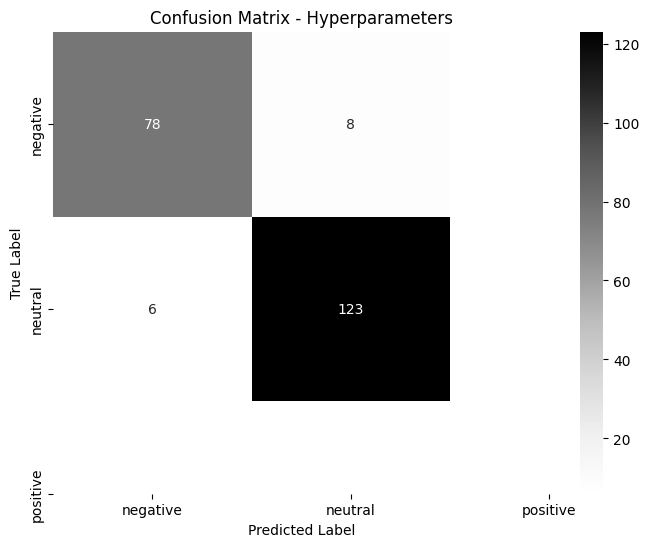

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_pred_best_pac_randomized)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greys', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix - Hyperparameters')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


MODEL PERFORMANCE COMPARISON


,Accuracy,Precision,Recall,F1-Score
Model,,,,
Passive Aggressive,0.934884,0.930000,0.930000,0.930000
SVM,0.000000,0.000000,0.000000,0.000000
Multinomial NB,0.000000,0.000000,0.000000,0.000000


<Figure size 1200x600 with 0 Axes>

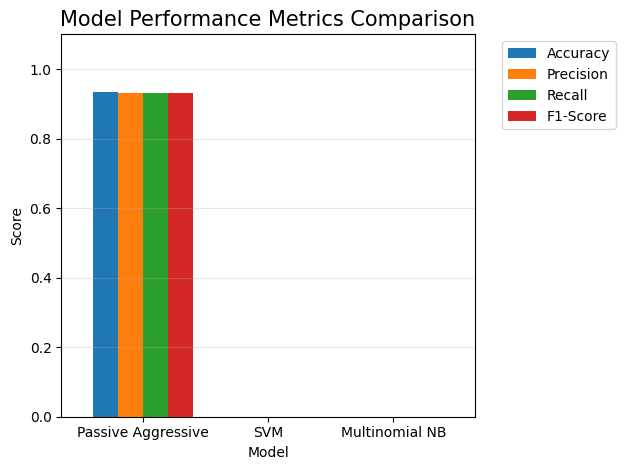

In [73]:
# ===========================================================================
# AIM 8: AI ALGORITHM COMPARISON - FIXED VERSION
# ===========================================================================

# 2. Parse classification reports
def parse_classification_report(report_str):
    """Convert sklearn classification report string to dict"""
    report_dict = {}
    lines = report_str.split('\n')
    
    # Get weighted averages
    weighted_line = [line for line in lines if 'weighted avg' in line][0]
    parts = weighted_line.split()
    
    report_dict['weighted avg'] = {
        'precision': float(parts[-4]),
        'recall': float(parts[-3]),
        'f1-score': float(parts[-2]),
        'support': int(float(parts[-1]))  # Convert to float first then int
    }
    return report_dict

report_rf = parse_classification_report(classification_rep_rf)
report_svm = parse_classification_report(classification_rep_svm)
report_nb = parse_classification_report(classification_rep_nb)

# 3. Create comparison DataFrame
model_comparison = pd.DataFrame({
    'Model': ['Passive Aggressive', 'SVM', 'Multinomial NB'],
    'Accuracy': [accuracy_rf, accuracy_svm, accuracy_nb],
    'Precision': [
        report_rf['weighted avg']['precision'],
        report_svm['weighted avg']['precision'],
        report_nb['weighted avg']['precision']
    ],
    'Recall': [
        report_rf['weighted avg']['recall'],
        report_svm['weighted avg']['recall'],
        report_nb['weighted avg']['recall']
    ],
    'F1-Score': [
        report_rf['weighted avg']['f1-score'],
        report_svm['weighted avg']['f1-score'],
        report_nb['weighted avg']['f1-score']
    ]
}).set_index('Model')

# 4. Display results
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
display(model_comparison.style.background_gradient(cmap='Blues'))

# 5. Visualization
plt.figure(figsize=(12, 6))
model_comparison[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', 
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
    width=0.8
)
plt.title('Model Performance Metrics Comparison', fontsize=15)
plt.ylim(0, 1.1)
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()